<a href="https://colab.research.google.com/github/anelglvz/Deep_Learning/blob/main/LSTM_for_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler


### Data
More details about data in: https://challengedata.ens.fr/challenges/89

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Contextual variables
* date d: YYYYMMDD is the date of the train id run
* train k: 1, 2, …, 55 train id (unique by day d)
* station s: AA, AB, AC,… is the station id
* hour: HH:00:00 is the time slot
* way: 0, 1 is the train way with 0 (toward Paris) or 1 (toward suburb)
* composition: 1, 2 is the number of train units (one or two)

Lags variables
* p1q0 ∈ [0,1] is the occupancy rate of the previous train k-1 at the same station s
* p2q0 ∈ [0,1] is the occupancy rate of the second previous train k-2 at the same station s
* p3q0 ∈ [0,1] is the occupancy rate of the third previous train k-3 at the same station s
* p0q1 ∈ [0,1] is the occupancy rate of the same train k at the previous station s-1
* p0q2 ∈ [0,1] is the occupancy rate of the same train k at the second previous station s-2
* p0q3 ∈ [0,1] is the occupancy rate of the same train k at the third previous station s-3

The actual occupancy rate is: p0q0 ∈ [0,1] which is crowding factor/occupancy rate, for a stop which is a train k at a station s for a day d.

In [ ]:
path = '/content/drive/MyDrive/Curso-Deep-Learning/Transformers_for_Time_Series/'
Xtrain = pd.read_csv(path+'Xtrain.csv')
index = Xtrain.index
print(Xtrain.shape)
Xtrain

(31119, 12)


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.8+ MB


In [ ]:
Xtrain['date'] = pd.to_datetime(Xtrain['date'])
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         31119 non-null  datetime64[ns]
 1   train        31119 non-null  int64         
 2   way          31119 non-null  int64         
 3   station      31119 non-null  object        
 4   hour         27915 non-null  object        
 5   composition  31119 non-null  int64         
 6   p1q0         29067 non-null  float64       
 7   p2q0         26974 non-null  float64       
 8   p3q0         24935 non-null  float64       
 9   p0q1         27917 non-null  float64       
 10  p0q2         24720 non-null  float64       
 11  p0q3         21527 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 2.8+ MB


In [ ]:
Xtrain['station'].unique()

array(['AD', 'AI', 'AJ', 'AK', 'AM', 'AT', 'AW', 'AX', 'BB', 'BD', 'BE',
       'AE', 'AL', 'AO', 'AQ', 'BC', 'AB', 'AN', 'AS', 'BF', 'BG', 'BH',
       'AV', 'AF', 'AP', 'AZ', 'AA', 'AC', 'AG', 'AH', 'AR', 'AU', 'BA',
       'BI', 'BJ', 'AY'], dtype=object)

In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         31119 non-null  datetime64[ns]
 1   train        31119 non-null  int64         
 2   way          31119 non-null  int64         
 3   station      31119 non-null  object        
 4   hour         27915 non-null  object        
 5   composition  31119 non-null  int64         
 6   p1q0         29067 non-null  float64       
 7   p2q0         26974 non-null  float64       
 8   p3q0         24935 non-null  float64       
 9   p0q1         27917 non-null  float64       
 10  p0q2         24720 non-null  float64       
 11  p0q3         21527 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 2.8+ MB


In [ ]:
datatrain = Xtrain.copy()
datatrain.set_index('date', inplace=True)
datatrain

,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
date,,,,,,,,,,,
2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN


In [ ]:
datatrain.iloc[58:2*58,:]

,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
date,,,,,,,,,,,
2019-01-07,1,0,AI,06:00:00,2,0.097000,0.166000,NaN,0.216,0.230,0.201
2019-01-08,1,0,AI,06:00:00,2,0.106000,0.177000,NaN,0.216,0.247,0.204
2019-01-10,1,0,AI,06:00:00,2,0.127000,0.140000,NaN,0.227,0.250,0.213
2019-01-11,1,0,AI,06:00:00,2,0.073000,0.160248,NaN,0.229,0.253,0.213
2019-01-14,1,0,AI,06:00:00,2,0.116000,0.158128,NaN,0.225,0.258,0.210
2019-01-15,1,0,AI,06:00:00,2,0.108000,0.151000,NaN,0.238,0.254,0.218
2019-01-17,1,0,AI,06:00:00,2,0.103000,0.160248,NaN,0.228,0.239,0.209
2019-01-18,1,0,AI,06:00:00,2,0.102000,0.126000,NaN,0.217,0.221,0.207
2019-01-21,1,0,AI,06:00:00,2,0.111120,0.146000,NaN,0.258,0.257,0.234


In [ ]:
aux = datatrain.loc['2019-01-07',:]
aux

,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
date,,,,,,,,,,,
2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
2019-01-07,1,0,AI,06:00:00,2,0.097,0.166,NaN,0.216,0.230,0.201
2019-01-07,1,0,AJ,06:00:00,2,0.149,0.183,0.16800,0.216,0.275,0.230
2019-01-07,1,0,AK,06:00:00,2,0.044,0.148,NaN,0.216,0.201,0.138
2019-01-07,1,0,AM,06:00:00,2,NaN,NaN,NaN,0.138,0.091,0.084
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-07,8,0,AW,08:00:00,2,0.183,0.202,0.24375,0.104,0.139,0.172
2019-01-07,8,0,AX,NaN,2,0.103,0.098,0.11100,NaN,NaN,NaN
2019-01-07,8,0,BB,08:00:00,2,0.530,0.400,0.62900,0.606,0.622,0.493


Data para el test!

In [ ]:
Xtest = pd.read_csv(path+'Xtest.csv')
index_t = Xtest.index
Xtest

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-05-21,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.226,0.165,0.128
1,2019-05-22,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.221,0.159,0.114
2,2019-05-27,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.227,0.175,0.133
3,2019-05-29,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.200,0.148,0.105
4,2019-06-03,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.221,0.169,0.126
...,...,...,...,...,...,...,...,...,...,...,...,...
13747,2019-07-03,9,0,BE,08:00:00,2,0.121,0.145,0.15715,0.071,0.095,NaN
13748,2019-07-04,9,0,BE,08:00:00,2,0.144,0.139,0.15300,0.079,0.102,NaN
13749,2019-07-05,9,0,BE,08:00:00,2,0.128,0.137,0.12700,0.072,0.089,NaN
13750,2019-05-28,9,0,BE,08:00:00,2,0.164,0.187,0.15500,0.100,0.130,NaN


In [ ]:
Xtest['date'] = pd.to_datetime(Xtest['date'])
Xtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13752 entries, 0 to 13751
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         13752 non-null  datetime64[ns]
 1   train        13752 non-null  int64         
 2   way          13752 non-null  int64         
 3   station      13752 non-null  object        
 4   hour         12346 non-null  object        
 5   composition  13752 non-null  int64         
 6   p1q0         12899 non-null  float64       
 7   p2q0         12007 non-null  float64       
 8   p3q0         11092 non-null  float64       
 9   p0q1         12352 non-null  float64       
 10  p0q2         10953 non-null  float64       
 11  p0q3         9556 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 1.3+ MB


In [ ]:
datatest = Xtest.copy()
datatest.set_index('date', inplace=True)
datatest

,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
date,,,,,,,,,,,
2019-05-21,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.226,0.165,0.128
2019-05-22,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.221,0.159,0.114
2019-05-27,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.227,0.175,0.133
2019-05-29,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.200,0.148,0.105
2019-06-03,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.221,0.169,0.126
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-03,9,0,BE,08:00:00,2,0.121,0.145,0.15715,0.071,0.095,NaN
2019-07-04,9,0,BE,08:00:00,2,0.144,0.139,0.15300,0.079,0.102,NaN
2019-07-05,9,0,BE,08:00:00,2,0.128,0.137,0.12700,0.072,0.089,NaN


In [ ]:
ysample = pd.read_csv(path+'Ysample.csv')
ysample

,Unnamed: 0,p0q0
0,1,0.288
1,2,0.788
2,3,0.409
3,4,0.883
4,5,0.940
...,...,...
13747,13748,0.373
13748,13749,0.732
13749,13750,0.273
13750,13751,0.728


In [ ]:
df_t = ysample[['p0q0']]
df_t = df_t.set_index(datatest.index, drop=True)
df_t

,p0q0
date,
2019-05-21,0.288
2019-05-22,0.788
2019-05-27,0.409
2019-05-29,0.883
2019-06-03,0.940
...,...
2019-07-03,0.373
2019-07-04,0.732
2019-07-05,0.273


In [ ]:
ytrain = pd.read_csv(path+'Ytrain.csv')
print(ytrain.shape)
ytrain

(31119, 2)


,Unnamed: 0,p0q0
0,1,0.216
1,2,0.216
2,3,0.227
3,4,0.229
4,5,0.225
...,...,...
31114,31115,0.111
31115,31116,0.143
31116,31117,0.139
31117,31118,0.117


In [ ]:
df = ytrain[['p0q0']]
df = df.set_index(datatrain.index, drop=True)
df

,p0q0
date,
2019-01-07,0.216
2019-01-08,0.216
2019-01-10,0.227
2019-01-11,0.229
2019-01-14,0.225
...,...
2019-05-13,0.111
2019-05-14,0.143
2019-05-15,0.139


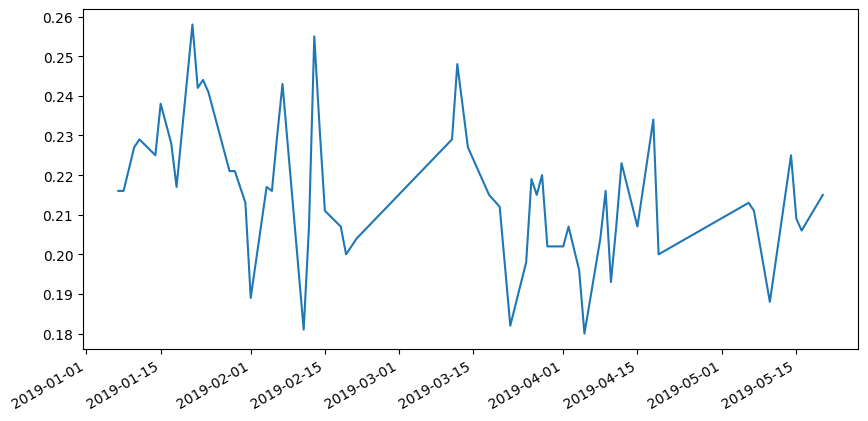

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:58])
plt.gcf().autofmt_xdate()
plt.show()

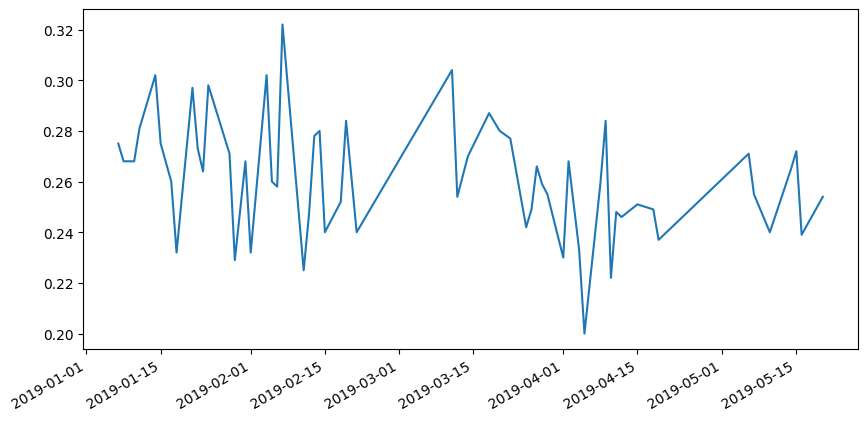

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[58:2*58])
plt.gcf().autofmt_xdate()
plt.show()

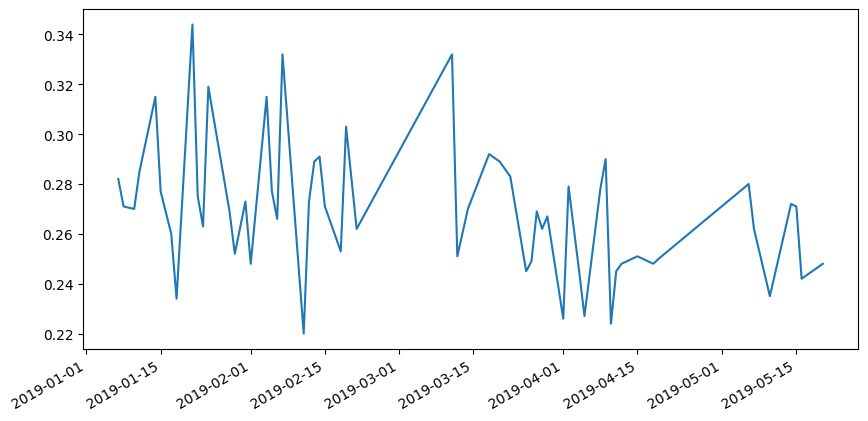

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df.iloc[2*58:3*58])
plt.gcf().autofmt_xdate()
plt.show()

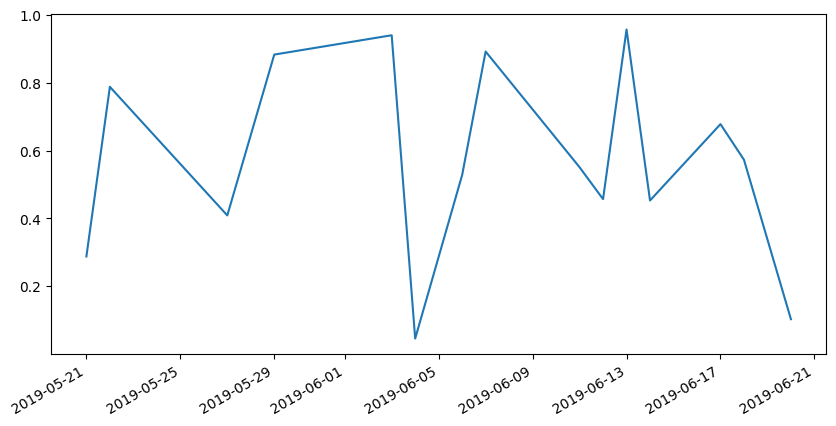

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(df_t.iloc[:15])
plt.gcf().autofmt_xdate()
plt.show()

Vamos a pronosticar para un solo tren!!

In [ ]:
datos = pd.concat([df,datatrain], axis=1)
datos = datos[['p0q0','p0q1',	'p0q2',	'p0q3','train', 'way', 'station', 'hour']]
datos = datos.dropna()
datos

,p0q0,p0q1,p0q2,p0q3,train,way,station,hour
date,,,,,,,,
2019-01-07,0.216,0.201,0.138,0.091,1,0,AD,06:00:00
2019-01-08,0.216,0.204,0.152,0.106,1,0,AD,06:00:00
2019-01-10,0.227,0.213,0.153,0.111,1,0,AD,06:00:00
2019-01-11,0.229,0.213,0.152,0.108,1,0,AD,06:00:00
2019-01-14,0.225,0.210,0.147,0.096,1,0,AD,06:00:00
...,...,...,...,...,...,...,...,...
2019-05-13,0.408,0.451,0.450,0.374,9,0,BB,08:00:00
2019-05-14,0.487,0.524,0.529,0.455,9,0,BB,08:00:00
2019-05-15,0.408,0.453,0.469,0.379,9,0,BB,08:00:00


In [ ]:
datos['hour'] = datos['hour'].apply(lambda x: float(x[1]))
datos

,p0q0,p0q1,p0q2,p0q3,train,way,station,hour
date,,,,,,,,
2019-01-07,0.216,0.201,0.138,0.091,1,0,AD,6.0
2019-01-08,0.216,0.204,0.152,0.106,1,0,AD,6.0
2019-01-10,0.227,0.213,0.153,0.111,1,0,AD,6.0
2019-01-11,0.229,0.213,0.152,0.108,1,0,AD,6.0
2019-01-14,0.225,0.210,0.147,0.096,1,0,AD,6.0
...,...,...,...,...,...,...,...,...
2019-05-13,0.408,0.451,0.450,0.374,9,0,BB,8.0
2019-05-14,0.487,0.524,0.529,0.455,9,0,BB,8.0
2019-05-15,0.408,0.453,0.469,0.379,9,0,BB,8.0


In [ ]:
rest = datos[datos['train'] == 1]
rest = pd.get_dummies(rest, prefix='station')
print(rest.shape)
rest

(464, 15)


,p0q0,p0q1,p0q2,p0q3,train,way,hour,station_AD,station_AI,station_AJ,station_AK,station_AM,station_AT,station_AW,station_BB
date,,,,,,,,,,,,,,,
2019-01-07,0.216,0.201,0.138,0.091,1,0,6.0,1,0,0,0,0,0,0,0
2019-01-08,0.216,0.204,0.152,0.106,1,0,6.0,1,0,0,0,0,0,0,0
2019-01-10,0.227,0.213,0.153,0.111,1,0,6.0,1,0,0,0,0,0,0,0
2019-01-11,0.229,0.213,0.152,0.108,1,0,6.0,1,0,0,0,0,0,0,0
2019-01-14,0.225,0.210,0.147,0.096,1,0,6.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-10,0.220,0.240,0.235,0.216,1,0,6.0,0,0,0,0,0,0,0,1
2019-05-14,0.255,0.265,0.272,0.227,1,0,6.0,0,0,0,0,0,0,0,1
2019-05-15,0.247,0.272,0.271,0.229,1,0,6.0,0,0,0,0,0,0,0,1


In [ ]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 464 entries, 2019-01-07 to 2019-05-20
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p0q0        464 non-null    float64
 1   p0q1        464 non-null    float64
 2   p0q2        464 non-null    float64
 3   p0q3        464 non-null    float64
 4   train       464 non-null    int64  
 5   way         464 non-null    int64  
 6   hour        464 non-null    float64
 7   station_AD  464 non-null    uint8  
 8   station_AI  464 non-null    uint8  
 9   station_AJ  464 non-null    uint8  
 10  station_AK  464 non-null    uint8  
 11  station_AM  464 non-null    uint8  
 12  station_AT  464 non-null    uint8  
 13  station_AW  464 non-null    uint8  
 14  station_BB  464 non-null    uint8  
dtypes: float64(5), int64(2), uint8(8)
memory usage: 32.6 KB


In [ ]:
X = rest.iloc[:,1:]
y = rest.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .8)

In [ ]:
X_train

,p0q1,p0q2,p0q3,train,way,hour,station_AD,station_AI,station_AJ,station_AK,station_AM,station_AT,station_AW,station_BB
date,,,,,,,,,,,,,,
2019-02-07,0.243,0.322,0.261,1,0,6.0,0,0,1,0,0,0,0,0
2019-04-08,0.039,0.061,0.081,1,0,6.0,0,0,0,0,0,0,1,0
2019-02-13,0.154,0.100,0.087,1,0,6.0,0,0,0,0,1,0,0,0
2019-05-07,0.139,0.100,0.091,1,0,6.0,0,0,0,0,1,0,0,0
2019-01-31,0.268,0.273,0.241,1,0,6.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-22,0.097,0.061,0.087,1,0,6.0,0,0,0,0,0,1,0,0
2019-02-06,0.230,0.208,0.143,1,0,6.0,0,0,0,1,0,0,0,0
2019-01-08,0.216,0.268,0.247,1,0,6.0,0,0,1,0,0,0,0,0


In [ ]:
y_train

date
2019-02-07    0.332
2019-04-08    0.087
2019-02-13    0.236
2019-05-07    0.197
2019-01-31    0.265
              ...  
2019-03-22    0.127
2019-02-06    0.233
2019-01-08    0.271
2019-04-12    0.223
2019-05-16    0.242
Name: p0q0, Length: 371, dtype: float64

Vamos a preparar los datos para la red!

In [ ]:
def data_prep(data1,data2):
  x = []
  y = []

  for i in range(data1.shape[0]):
    x.append(data1.iloc[i, [2,1,0]]) # Registra todos lo data_train en bloques de 3 estaciones
    y.append(data2.iloc[i]) # Registra todos los datos de ytrain

  x = np.array(x)
  y = np.array(y)

  x = x.reshape(data1.shape[0],3,1)
  y = y.reshape(-1,1)

  X = np.zeros((data1.shape[0],3,data1.shape[1]-2))
  for i in range(data1.shape[0]):
    for j in range(3):
      X[i][j] = np.append(x[i][j],data1.iloc[i, 3:])

  return X,y

In [ ]:
xtrain3, ytrain3 = data_prep(X_train,y_train)
print(xtrain3)
print(ytrain3)
xtrain3.shape, ytrain3.shape

[[[0.261 1.    0.    ... 0.    0.    0.   ]
  [0.322 1.    0.    ... 0.    0.    0.   ]
  [0.243 1.    0.    ... 0.    0.    0.   ]]

 [[0.081 1.    0.    ... 0.    1.    0.   ]
  [0.061 1.    0.    ... 0.    1.    0.   ]
  [0.039 1.    0.    ... 0.    1.    0.   ]]

 [[0.087 1.    0.    ... 0.    0.    0.   ]
  [0.1   1.    0.    ... 0.    0.    0.   ]
  [0.154 1.    0.    ... 0.    0.    0.   ]]

 ...

 [[0.247 1.    0.    ... 0.    0.    0.   ]
  [0.268 1.    0.    ... 0.    0.    0.   ]
  [0.216 1.    0.    ... 0.    0.    0.   ]]

 [[0.101 1.    0.    ... 0.    0.    0.   ]
  [0.153 1.    0.    ... 0.    0.    0.   ]
  [0.211 1.    0.    ... 0.    0.    0.   ]]

 [[0.214 1.    0.    ... 0.    0.    0.   ]
  [0.239 1.    0.    ... 0.    0.    0.   ]
  [0.206 1.    0.    ... 0.    0.    0.   ]]]
[[0.332]
 [0.087]
 [0.236]
 [0.197]
 [0.265]
 [0.204]
 [0.332]
 [0.303]
 [0.234]
 [0.211]
 [0.302]
 [0.2  ]
 [0.193]
 [0.199]
 [0.193]
 [0.225]
 [0.132]
 [0.23 ]
 [0.284]
 [0.149]
 [0.258]
 

((371, 3, 12), (371, 1))

In [ ]:
xtest3, ytest3 = data_prep(X_test,y_test)
print(xtest3)
print(ytest3)
xtest3.shape, ytest3.shape

[[[0.222 1.    0.    ... 0.    0.    1.   ]
  [0.262 1.    0.    ... 0.    0.    1.   ]
  [0.24  1.    0.    ... 0.    0.    1.   ]]

 [[0.228 1.    0.    ... 0.    0.    1.   ]
  [0.273 1.    0.    ... 0.    0.    1.   ]
  [0.247 1.    0.    ... 0.    0.    1.   ]]

 [[0.233 1.    0.    ... 0.    0.    0.   ]
  [0.258 1.    0.    ... 0.    0.    0.   ]
  [0.23  1.    0.    ... 0.    0.    0.   ]]

 ...

 [[0.102 1.    0.    ... 1.    0.    0.   ]
  [0.08  1.    0.    ... 1.    0.    0.   ]
  [0.119 1.    0.    ... 1.    0.    0.   ]]

 [[0.105 1.    0.    ... 0.    0.    0.   ]
  [0.148 1.    0.    ... 0.    0.    0.   ]
  [0.199 1.    0.    ... 0.    0.    0.   ]]

 [[0.25  1.    0.    ... 0.    0.    0.   ]
  [0.284 1.    0.    ... 0.    0.    0.   ]
  [0.216 1.    0.    ... 0.    0.    0.   ]]]
[[0.268]
 [0.268]
 [0.266]
 [0.28 ]
 [0.111]
 [0.207]
 [0.207]
 [0.236]
 [0.166]
 [0.214]
 [0.119]
 [0.257]
 [0.214]
 [0.284]
 [0.201]
 [0.241]
 [0.264]
 [0.2  ]
 [0.221]
 [0.27 ]
 [0.344]
 

((93, 3, 12), (93, 1))

Modelo LSTM

In [ ]:
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


In [ ]:
model = Sequential()

model.add(LSTM(units=245,return_sequences=True, input_shape=(xtrain3.shape[1],xtrain3.shape[2])))
model.add(LSTM(units=245,return_sequences=True))
model.add(LSTM(units=245,return_sequences=True))
model.add(LSTM(units=245))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 245)            252840    
                                                                 
 lstm_1 (LSTM)               (None, 3, 245)            481180    
                                                                 
 lstm_2 (LSTM)               (None, 3, 245)            481180    
                                                                 
 lstm_3 (LSTM)               (None, 245)               481180    
                                                                 
 dense (Dense)               (None, 1)                 246       
                                                                 
Total params: 1,696,626
Trainable params: 1,696,626
Non-trainable params: 0
_________________________________________________________________


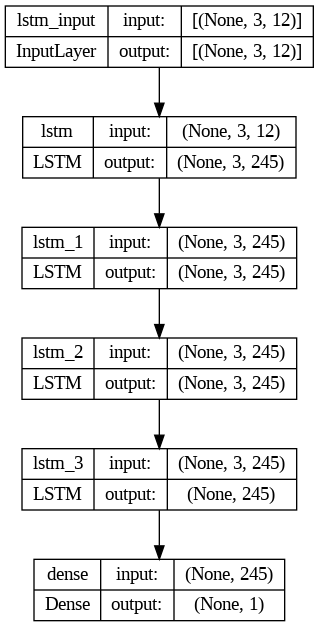

In [ ]:
tf.keras.utils.plot_model(
    model,
    #to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    #rankdir="LR",
    #dpi=96,
)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
%%time
res = model.fit(xtrain3, ytrain3,  epochs=10, batch_size=5)

Epoch 1/10
75/75 [==============================] - 13s 55ms/step - loss: 0.0041 - mae: 0.0463
Epoch 2/10
75/75 [==============================] - 5s 71ms/step - loss: 0.0013 - mae: 0.0241
Epoch 3/10
75/75 [==============================] - 5s 67ms/step - loss: 9.5289e-04 - mae: 0.0192
Epoch 4/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0010 - mae: 0.0204
Epoch 5/10
75/75 [==============================] - 5s 66ms/step - loss: 0.0013 - mae: 0.0240
Epoch 6/10
75/75 [==============================] - 6s 80ms/step - loss: 0.0011 - mae: 0.0211
Epoch 7/10
75/75 [==============================] - 4s 54ms/step - loss: 0.0011 - mae: 0.0205
Epoch 8/10
75/75 [==============================] - 5s 69ms/step - loss: 0.0010 - mae: 0.0196
Epoch 9/10
75/75 [==============================] - 5s 67ms/step - loss: 0.0012 - mae: 0.0231
Epoch 10/10
75/75 [==============================] - 4s 55ms/step - loss: 9.7507e-04 - mae: 0.0187
CPU times: user 1min 11s, sys: 2.78 s, total: 1min

Predicciones

In [ ]:
y_pred = model.predict(xtrain3)

12/12 [==============================] - 2s 19ms/step


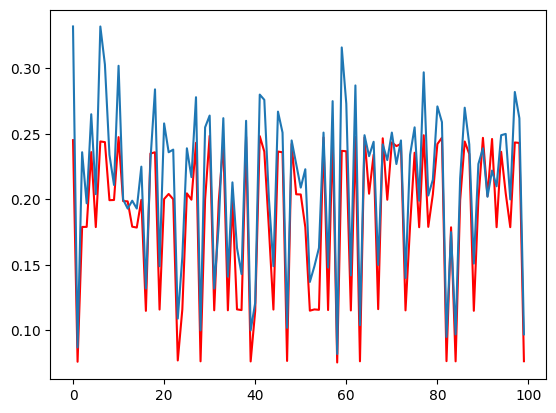

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_pred[:100],c='r')
ax.plot(ytrain3[:100])
plt.show()

In [ ]:
y_pred_t = model.predict(xtest3)

3/3 [==============================] - 0s 30ms/step


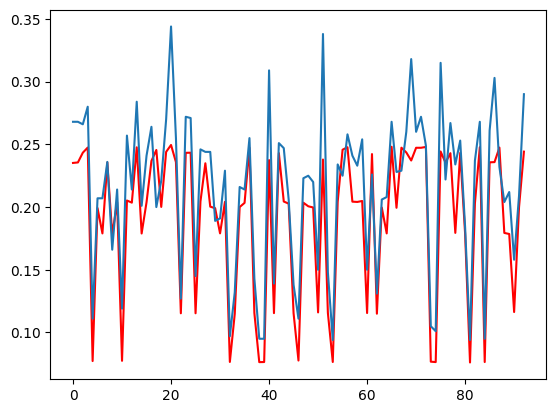

In [ ]:
fig, ax = plt.subplots()

ax.plot(y_pred_t[:100],c='r')
ax.plot(ytest3[:100])
plt.show()

Tarea:



*   Obtener pronósticos para $p_0q_0$ con otro tren
*   Obtener pronósticos para $p_0q_0$ dejando fija una estación

